In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
data_import = pd.read_csv("clothing_size.csv")
data_import

weight   age  height size
0           62  28.0  172.72   XL
1           59  36.0  167.64    L
2           61  34.0  165.10    M
3           65  27.0  175.26    L
4           62  45.0  172.72    M
...        ...   ...     ...  ...
119729      63  42.0  175.26    M
119730      45  29.0  154.94    S
119731      61  31.0  172.72    M
119732      74  31.0  167.64   XL
119733      70  30.0  167.64   XL

[119734 rows x 4 columns]

In [4]:
data_import["size"].value_counts()

size
M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: count, dtype: int64

## Data Preparation

### Dealing with NA

There are over 100K records here, so we'll just drop NA values

In [5]:
data_step_one = data_import.copy()

data_step_one = data_step_one.dropna(axis=0)

dropped_rows = len(data_import) - len(data_step_one)

print("Rows Dropped: ", dropped_rows)

Rows Dropped:  581


We'll also drop the XXL records since we don't have a representative amount of this data

In [6]:
data_step_one = data_step_one[data_step_one["size"] != "XXL"]
data_step_one

weight   age  height size
0           62  28.0  172.72   XL
1           59  36.0  167.64    L
2           61  34.0  165.10    M
3           65  27.0  175.26    L
4           62  45.0  172.72    M
...        ...   ...     ...  ...
119729      63  42.0  175.26    M
119730      45  29.0  154.94    S
119731      61  31.0  172.72    M
119732      74  31.0  167.64   XL
119733      70  30.0  167.64   XL

[119084 rows x 4 columns]

In [7]:
X = data_step_one[["weight", "age", "height"]]
y = data_step_one["size"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Modeling

### Single Run

In [9]:
def decision_tree_run(depth):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train, y_train)
    return tree_clf.score(X_test, y_test)
decision_tree_run(None)

0.5039951142551784

### Multiple Runs with Different Tree Depths

In [10]:
accuracy = []
tree_depth = list(range(2, 100, 3))

In [11]:
for i in tree_depth:
    accuracy.append(decision_tree_run(i))
accuracy

[0.446791185302051,
 0.5029009109878365,
 0.5121634688788234,
 0.5137666038984172,
 0.5075576365209425,
 0.5045803857702682,
 0.5043513664817548,
 0.5039187744923406,
 0.504147793780854,
 0.5040714540180162,
 0.503893327904728,
 0.5040714540180162,
 0.5041732403684666,
 0.5038424347295027,
 0.5038678813171154,
 0.5040969006056288,
 0.5037915415542775,
 0.5040714540180162,
 0.5040460074304036,
 0.504147793780854,
 0.5037915415542775,
 0.5038424347295027,
 0.503893327904728,
 0.5036134154409894,
 0.504020560842791,
 0.503893327904728,
 0.5037152017914398,
 0.5038169881418901,
 0.503893327904728,
 0.5039442210799532,
 0.5038678813171154,
 0.504020560842791,
 0.5040714540180162]

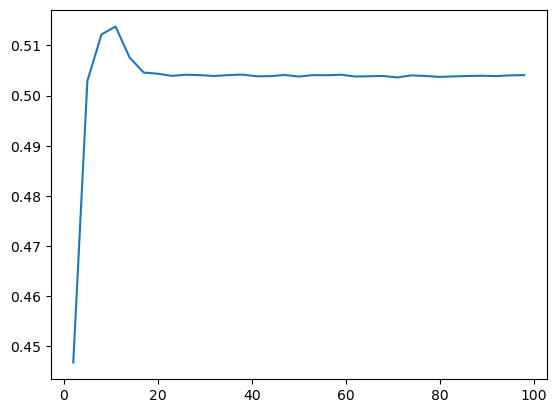

In [12]:
plt.plot(tree_depth, accuracy)

## Evaluation

### Decision Tree Graph

In [13]:
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names = X_train.columns,
    rounded=True,
    filled=True
)

In [14]:
results = pd.DataFrame(data = {"Predictions":tree_clf.predict(X_test).tolist(), "Actuals": y_test.to_list()})
results["Matching"] = results.apply(lambda x: "Correct" if x["Predictions"] == x["Actuals"] else "Wrong", axis=1)
results

Predictions Actuals Matching
0               M       L    Wrong
1              XL       M    Wrong
2             XXS     XXS  Correct
3               M       M  Correct
4            XXXL      XL    Wrong
...           ...     ...      ...
39293           M       M  Correct
39294           S     XXS    Wrong
39295           S       S  Correct
39296          XL    XXXL    Wrong
39297          XL    XXXL    Wrong

[39298 rows x 3 columns]

In [15]:
correct_wrong_data = results.groupby(["Actuals", "Matching"])["Predictions"].count().reset_index()
correct_wrong_data["Labels"] = correct_wrong_data["Actuals"] + " - " + correct_wrong_data["Matching"]
correct_wrong_data["Colors"] = correct_wrong_data["Matching"].map(lambda x: "b" if x == "Correct" else "r")
correct_wrong_data

Actuals Matching  Predictions          Labels Colors
0        L  Correct         1555     L - Correct      b
1        L    Wrong         4216       L - Wrong      r
2        M  Correct         5737     M - Correct      b
3        M    Wrong         3968       M - Wrong      r
4        S  Correct         3402     S - Correct      b
5        S    Wrong         3745       S - Wrong      r
6       XL  Correct         2687    XL - Correct      b
7       XL    Wrong         3537      XL - Wrong      r
8      XXS  Correct         1268   XXS - Correct      b
9      XXS    Wrong         2047     XXS - Wrong      r
10    XXXL  Correct         5114  XXXL - Correct      b
11    XXXL    Wrong         2022    XXXL - Wrong      r

<BarContainer object of 12 artists>

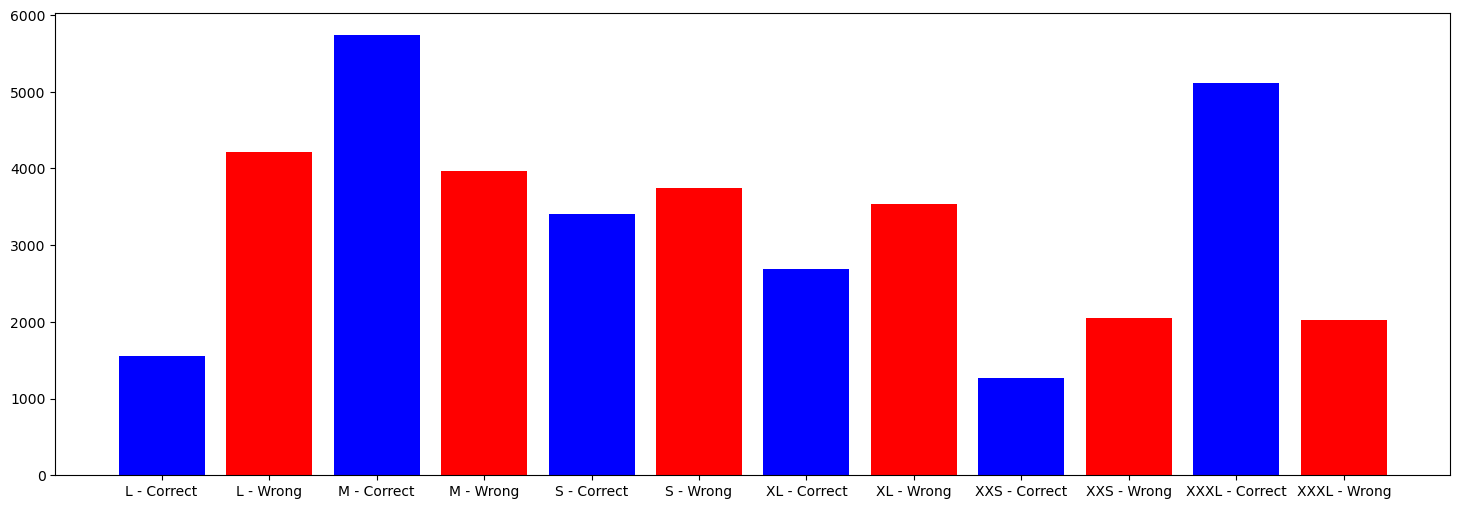

In [16]:
plt.figure(figsize=(18, 6))
fig = plt.bar(x=correct_wrong_data["Labels"], height=correct_wrong_data["Predictions"], color=correct_wrong_data["Colors"])
fig

In [17]:
confusion_matrix(y_test, tree_clf.predict(X_test).tolist(), labels=y_test.unique())

array([[1555, 2069,    9, 1648,  316,  174],
       [1321, 5737,  130,  695,   97, 1725],
       [   8,  360, 1268,   10,    7, 1662],
       [1254, 1018,   11, 2687, 1154,  100],
       [ 316,  155,    5, 1524, 5114,   22],
       [ 182, 2679,  796,   66,   22, 3402]])

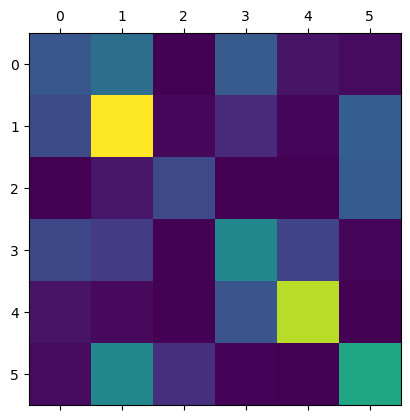

In [18]:
plt.matshow(confusion_matrix(y_test, tree_clf.predict(X_test).tolist(), labels=y_test.unique()))